In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<h4>XGBoost</h4>
https://xgboost.readthedocs.io/en/latest/ <br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=api#module-xgboost.sklearn <br>
https://www.lfd.uci.edu/~gohlke/pythonlibs <br>

In [26]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import re
from tqdm.notebook import tqdm
import warnings
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz


In [27]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

<h4>학습데이터 로드</h4>

In [28]:
ls "."

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON\2020_DACON-Kaggle\소설저자AI 디렉터리

2020-12-04  오후 02:08    <DIR>          .
2020-12-04  오후 02:08    <DIR>          ..
2020-12-04  오후 12:36    <DIR>          .ipynb_checkpoints
2020-11-26  오후 10:42            75,612 15_lstm_glove_inhoinho_v0_1.ipynb
2020-12-02  오후 06:12            76,044 15_lstm_glove_inhoinho_v0_2_ipynb의_사본.ipynb
2020-11-26  오후 08:29            38,607 15-lstm-glove-inho.ipynb
2020-11-24  오전 10:49            33,874 Augmentation.ipynb
2020-12-01  오후 04:01    <DIR>          build
2020-12-02  오후 09:19           318,220 CNN_CV_shared.ipynb
2020-12-04  오전 01:10            98,597 CNN_CV_shared-Refactoring.ipynb
2020-11-24  오전 11:15    <DIR>          dataset
2020-11-26  오후 08:29    <DIR>          dku-kaggle-class
2020-12-04  오전 06:00           113,621 DNN_CV_shared-Refactoring.ipynb
2020-12-01  오후 04:01    <DIR>          drive
2020-11-05  오후 05:31    <DIR>          ensemble
2020-11-26  오후 11:01           874,542 Logis

In [29]:
data_dir = Path('./open')
trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
submission = pd.read_csv("./open/sample_submission.csv")

val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./ensemble/build/sub')
glove_file = './dataset/glove.6B/glove.6B.200d.txt'

algo_name = 'xgbcv'
feature_name = 'tfidf'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
seed = 42


<h4> Train/Test 데이터 분석하기 </h4>

In [30]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)

print(train.info())
print(test.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183468 entries, 0 to 183467
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   183468 non-null  int64 
 1   text    183468 non-null  object
 2   author  183468 non-null  int64 
 3   length  183468 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19617 entries, 0 to 19616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   19617 non-null  int64 
 1   text    19617 non-null  object
dtypes: int64(1), object(1)
memory usage: 306.6+ KB
None
(183468, 4)


<h2> 문자열 전처리

In [31]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [32]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [33]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,level_0,index,author,length
count,181013.0000,181013.0000,181013.0000,181013.0000
mean,91514.5870,91514.5870,2.0491,164.5379
std,53025.4182,53025.4182,1.2863,178.6952
min,0.0000,0.0000,0.0000,20.0000
25%,45490.0000,45490.0000,1.0000,65.0000
50%,91441.0000,91441.0000,2.0000,113.0000
75%,137458.0000,137458.0000,3.0000,189.0000
max,183467.0000,183467.0000,4.0000,2454.0000


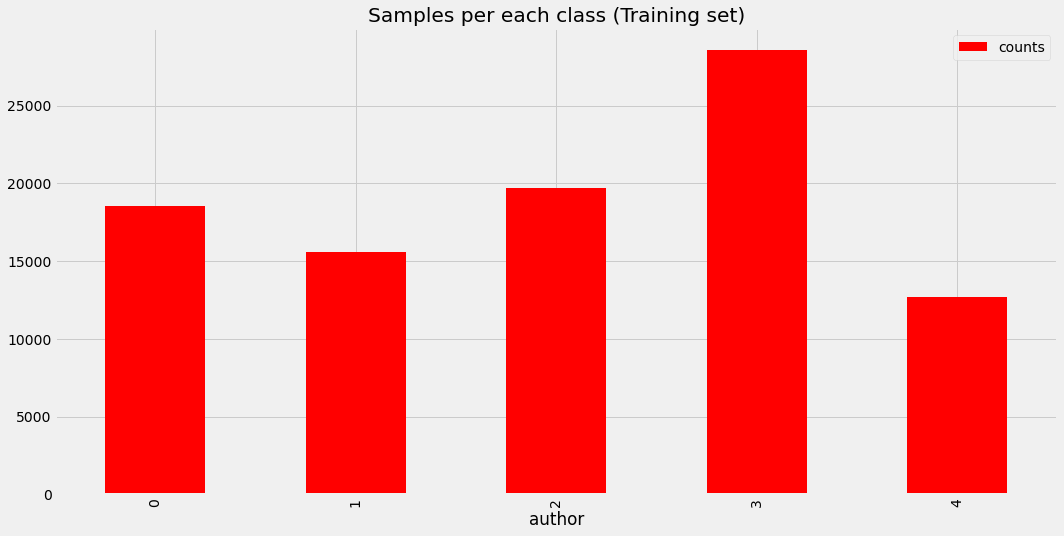

In [34]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')

In [35]:
df = df.drop(columns = ['level_0'])
df = df.reset_index()
df['index'] = df['index'].reset_index()

In [36]:
train = df
train= train.drop(columns=['level_0'])
train

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,235
1,1,sister asked suppose,2,34
2,2,engaged one day walked perusing janes last let...,1,312
3,3,captain porch keeping carefully way treacherou...,4,305
4,4,mercy gentlemen odin flung hands dont write an...,3,215
...,...,...,...,...
95080,95080,diningroom soon joined odin odin busily engage...,1,150
95081,95081,one came books toilette,1,56
95082,95082,faces however tolerably calm no change visible...,1,252
95083,95083,still ticking hall,2,29


In [37]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(95085,) (19617,) (95085,)


<h3> Lemmatization > Tfidf </h3> 

In [38]:
import nltk
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

cols_to_use 설정하기

In [39]:

lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

train['text'] = train['text'].apply(lemmatize_text)
test['text'] = test['text'].apply(lemmatize_text)

In [40]:
def to__string(text):
    return ' '.join(text)

train['text'] = train['text'].apply(to__string)
test['text'] = test['text'].apply(to__string)

In [41]:
tfidf_model = TfidfVectorizer(max_features = 1000)
df = pd.DataFrame(tfidf_model.fit_transform(train['text']).todense())


In [42]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.1804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3469,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5101,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [43]:
tst = pd.DataFrame(tfidf_model.fit_transform(test['text']).todense())
y = train['author']
trn = df

In [44]:
trn = df
print(trn.shape, y.shape, tst.shape)

(95085, 1000) (95085,) (19617, 1000)


<h1> XGBoost</h1>

In [46]:
n_fold = 5
n_class = 5

In [47]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

<h4> Train Split </h4>

In [48]:
#Normal
X = trn
seed = 8
test_size = 0.2
#10%는 테스트용, 90%는 학습용
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size , random_state = seed)
print(X_train.shape,X_test.shape)

(76068, 1000) (19017, 1000)


In [49]:
y_train

36418    2
44783    4
55686    2
2882     2
38017    3
        ..
10376    3
62426    3
18417    1
25940    2
70083    4
Name: author, Length: 76068, dtype: int64

In [52]:
#최적 파라미터 찾는 부분
params = {
    "objective": "multi:softmax",
    "n_estimators": 1000,
    "random_state": seed,
    "n_jobs": -1
}

space = {
    'max_depth' : hp.choice('max_depth', range(5, 18, 1)),
    'min_child_weight' : hp.quniform('min_child_weight', 5, 20, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.1),
    'subsample' : hp.quniform('subsample', 0.7, 1.05, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1.0, 0.05)
}

In [55]:
def objective(hyperparams):
    model = XGBClassifier(**params, **hyperparams)
    model.fit(X=X_train, y=y_train,
              eval_set=[(X_test, y_test)],
              eval_metric="mlogloss",
              early_stopping_rounds=10,
              verbose=False)
    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
#n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

  0%|          | 0/10 [16:04<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

//ParamDone

xg2. KFold Stratified

1. Hyperparam + KFoldStratified XGB 

In [32]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    xgb_clf0 = XGBClassifier(**params)
    xgb_clf0.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=80)
    
    p_val[i_val, :] =xgb_clf0.predict_proba(trn[i_val])
    p_tst += xgb_clf0.predict_proba(tst) / n_fold

training model for CV #1
[0]	validation_0-merror:0.07925
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07598
[2]	validation_0-merror:0.07892
[3]	validation_0-merror:0.07755
[4]	validation_0-merror:0.08164
[5]	validation_0-merror:0.08022
[6]	validation_0-merror:0.07809
[7]	validation_0-merror:0.07714
[8]	validation_0-merror:0.07448
[9]	validation_0-merror:0.07402
[10]	validation_0-merror:0.07447
[11]	validation_0-merror:0.07412
[12]	validation_0-merror:0.07461
[13]	validation_0-merror:0.07448
[14]	validation_0-merror:0.07422
[15]	validation_0-merror:0.07336
[16]	validation_0-merror:0.07355
[17]	validation_0-merror:0.07334
[18]	validation_0-merror:0.07284
[19]	validation_0-merror:0.07212
[20]	validation_0-merror:0.07225
[21]	validation_0-merror:0.07225
[22]	validation_0-merror:0.07250
[23]	validation_0-merror:0.07261
[24]	validation_0-merror:0.07236
[25]	validation_0-merror:0.07186
[26]	validation_0-merror:0.07164
[27]	validation_0-merror:0.

[242]	validation_0-merror:0.06638
[243]	validation_0-merror:0.06638
[244]	validation_0-merror:0.06641
[245]	validation_0-merror:0.06636
[246]	validation_0-merror:0.06633
[247]	validation_0-merror:0.06636
[248]	validation_0-merror:0.06631
[249]	validation_0-merror:0.06647
[250]	validation_0-merror:0.06641
[251]	validation_0-merror:0.06636
[252]	validation_0-merror:0.06636
[253]	validation_0-merror:0.06639
[254]	validation_0-merror:0.06647
[255]	validation_0-merror:0.06648
[256]	validation_0-merror:0.06645
[257]	validation_0-merror:0.06647
[258]	validation_0-merror:0.06644
[259]	validation_0-merror:0.06641
[260]	validation_0-merror:0.06638
[261]	validation_0-merror:0.06644
[262]	validation_0-merror:0.06642
[263]	validation_0-merror:0.06644
[264]	validation_0-merror:0.06642
[265]	validation_0-merror:0.06647
[266]	validation_0-merror:0.06636
[267]	validation_0-merror:0.06633
[268]	validation_0-merror:0.06631
[269]	validation_0-merror:0.06625
[270]	validation_0-merror:0.06638
[271]	validati

[46]	validation_0-merror:0.07013
[47]	validation_0-merror:0.07005
[48]	validation_0-merror:0.06994
[49]	validation_0-merror:0.06981
[50]	validation_0-merror:0.06980
[51]	validation_0-merror:0.06978
[52]	validation_0-merror:0.06972
[53]	validation_0-merror:0.06980
[54]	validation_0-merror:0.06966
[55]	validation_0-merror:0.06955
[56]	validation_0-merror:0.06936
[57]	validation_0-merror:0.06933
[58]	validation_0-merror:0.06919
[59]	validation_0-merror:0.06933
[60]	validation_0-merror:0.06925
[61]	validation_0-merror:0.06908
[62]	validation_0-merror:0.06892
[63]	validation_0-merror:0.06886
[64]	validation_0-merror:0.06897
[65]	validation_0-merror:0.06898
[66]	validation_0-merror:0.06888
[67]	validation_0-merror:0.06886
[68]	validation_0-merror:0.06877
[69]	validation_0-merror:0.06886
[70]	validation_0-merror:0.06883
[71]	validation_0-merror:0.06875
[72]	validation_0-merror:0.06873
[73]	validation_0-merror:0.06870
[74]	validation_0-merror:0.06855
[75]	validation_0-merror:0.06856
[76]	valid

[289]	validation_0-merror:0.06700
[290]	validation_0-merror:0.06700
[291]	validation_0-merror:0.06700
[292]	validation_0-merror:0.06705
[293]	validation_0-merror:0.06697
[294]	validation_0-merror:0.06692
[295]	validation_0-merror:0.06692
[296]	validation_0-merror:0.06681
[297]	validation_0-merror:0.06673
[298]	validation_0-merror:0.06678
[299]	validation_0-merror:0.06677
[300]	validation_0-merror:0.06683
[301]	validation_0-merror:0.06673
[302]	validation_0-merror:0.06675
[303]	validation_0-merror:0.06673
[304]	validation_0-merror:0.06673
[305]	validation_0-merror:0.06678
[306]	validation_0-merror:0.06684
[307]	validation_0-merror:0.06684
[308]	validation_0-merror:0.06694
[309]	validation_0-merror:0.06692
[310]	validation_0-merror:0.06694
[311]	validation_0-merror:0.06694
[312]	validation_0-merror:0.06684
[313]	validation_0-merror:0.06689
[314]	validation_0-merror:0.06692
[315]	validation_0-merror:0.06694
[316]	validation_0-merror:0.06697
[317]	validation_0-merror:0.06700
[318]	validati

[186]	validation_0-merror:0.06636
[187]	validation_0-merror:0.06639
[188]	validation_0-merror:0.06641
[189]	validation_0-merror:0.06633
[190]	validation_0-merror:0.06628
[191]	validation_0-merror:0.06633
[192]	validation_0-merror:0.06636
[193]	validation_0-merror:0.06630
[194]	validation_0-merror:0.06630
[195]	validation_0-merror:0.06631
[196]	validation_0-merror:0.06625
[197]	validation_0-merror:0.06633
[198]	validation_0-merror:0.06631
[199]	validation_0-merror:0.06641
[200]	validation_0-merror:0.06630
[201]	validation_0-merror:0.06619
[202]	validation_0-merror:0.06625
[203]	validation_0-merror:0.06617
[204]	validation_0-merror:0.06617
[205]	validation_0-merror:0.06608
[206]	validation_0-merror:0.06608
[207]	validation_0-merror:0.06608
[208]	validation_0-merror:0.06608
[209]	validation_0-merror:0.06616
[210]	validation_0-merror:0.06617
[211]	validation_0-merror:0.06619
[212]	validation_0-merror:0.06614
[213]	validation_0-merror:0.06606
[214]	validation_0-merror:0.06611
[215]	validati

[114]	validation_0-merror:0.06808
[115]	validation_0-merror:0.06811
[116]	validation_0-merror:0.06813
[117]	validation_0-merror:0.06819
[118]	validation_0-merror:0.06825
[119]	validation_0-merror:0.06823
[120]	validation_0-merror:0.06817
[121]	validation_0-merror:0.06819
[122]	validation_0-merror:0.06819
[123]	validation_0-merror:0.06825
[124]	validation_0-merror:0.06823
[125]	validation_0-merror:0.06822
[126]	validation_0-merror:0.06827
[127]	validation_0-merror:0.06827
[128]	validation_0-merror:0.06819
[129]	validation_0-merror:0.06814
[130]	validation_0-merror:0.06805
[131]	validation_0-merror:0.06811
[132]	validation_0-merror:0.06803
[133]	validation_0-merror:0.06806
[134]	validation_0-merror:0.06805
[135]	validation_0-merror:0.06805
[136]	validation_0-merror:0.06803
[137]	validation_0-merror:0.06809
[138]	validation_0-merror:0.06816
[139]	validation_0-merror:0.06822
[140]	validation_0-merror:0.06817
[141]	validation_0-merror:0.06808
[142]	validation_0-merror:0.06802
[143]	validati

[355]	validation_0-merror:0.06711
[356]	validation_0-merror:0.06716
[357]	validation_0-merror:0.06723
[358]	validation_0-merror:0.06717
[359]	validation_0-merror:0.06717
[360]	validation_0-merror:0.06716
[361]	validation_0-merror:0.06711
[362]	validation_0-merror:0.06714
[363]	validation_0-merror:0.06706
[364]	validation_0-merror:0.06708
[365]	validation_0-merror:0.06694
[366]	validation_0-merror:0.06694
[367]	validation_0-merror:0.06697
[368]	validation_0-merror:0.06698
[369]	validation_0-merror:0.06697
[370]	validation_0-merror:0.06698
[371]	validation_0-merror:0.06700
[372]	validation_0-merror:0.06705
[373]	validation_0-merror:0.06703
[374]	validation_0-merror:0.06700
[375]	validation_0-merror:0.06697
[376]	validation_0-merror:0.06700
[377]	validation_0-merror:0.06700
[378]	validation_0-merror:0.06698
[379]	validation_0-merror:0.06695
[380]	validation_0-merror:0.06697
[381]	validation_0-merror:0.06691
[382]	validation_0-merror:0.06694
[383]	validation_0-merror:0.06689
[384]	validati

[110]	validation_0-merror:0.06502
[111]	validation_0-merror:0.06502
[112]	validation_0-merror:0.06500
[113]	validation_0-merror:0.06497
[114]	validation_0-merror:0.06494
[115]	validation_0-merror:0.06488
[116]	validation_0-merror:0.06486
[117]	validation_0-merror:0.06486
[118]	validation_0-merror:0.06475
[119]	validation_0-merror:0.06478
[120]	validation_0-merror:0.06477
[121]	validation_0-merror:0.06484
[122]	validation_0-merror:0.06483
[123]	validation_0-merror:0.06478
[124]	validation_0-merror:0.06466
[125]	validation_0-merror:0.06464
[126]	validation_0-merror:0.06478
[127]	validation_0-merror:0.06464
[128]	validation_0-merror:0.06463
[129]	validation_0-merror:0.06461
[130]	validation_0-merror:0.06464
[131]	validation_0-merror:0.06461
[132]	validation_0-merror:0.06455
[133]	validation_0-merror:0.06450
[134]	validation_0-merror:0.06442
[135]	validation_0-merror:0.06444
[136]	validation_0-merror:0.06445
[137]	validation_0-merror:0.06456
[138]	validation_0-merror:0.06452
[139]	validati

In [33]:
print('hyper xgb + kfold :')
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

hyper xgb + kfold :
93.4156%


In [34]:
print(p_val.shape, p_tst.shape)

(320000, 3) (320000, 3)


In [40]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

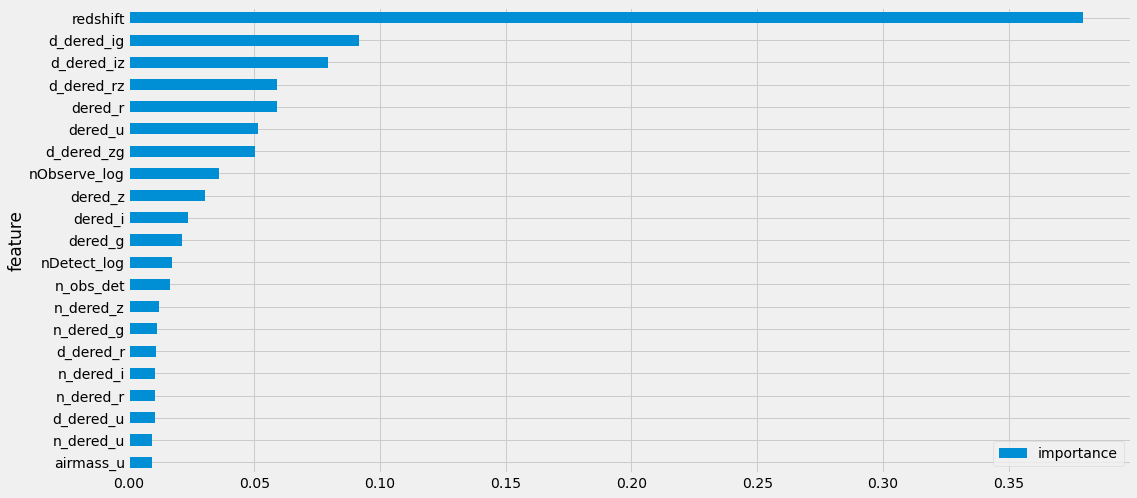

In [41]:
imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': xgb_clf0.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')


2. personal param + KFoldStratified XGB 

In [44]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    xgb_clf1 = XGBClassifier(n_estimators = 800, 
                        min_child_weight = 4 ,
                        max_depth =11,
                        learning_rate = 0.115,
                        verbose = False,
                        objective = 'multi:softmax')
    xgb_clf1.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=80)
    
    p_val[i_val, :] =xgb_clf1.predict_proba(trn[i_val])
    p_tst += xgb_clf1.predict_proba(tst) / n_fold

training model for CV #1
[00:39:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.08225
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07900
[2]	validation_0-merror:0.07778
[3]	validation_0-merror:0.07692
[4]	validation_0-merror:0.07687
[5]	validation_0-merror:0.07619
[6]	validation_0-merror:0.07578
[7]	validation_0-merror:0.07522
[8]	validation_0-merror:0.07486
[9]	validation_0-merror:0.07450
[10]	validation_0-merror:0.07433
[11]	validation_0-merror:0.07381
[12]	validation_0-merror:0.07347
[13]	validation_0-merror:0.07320
[14]	validation_0-merror:0.07233
[15]	validation_0-merror:0.07227
[16]	

[14]	validation_0-merror:0.07439
[15]	validation_0-merror:0.07391
[16]	validation_0-merror:0.07364
[17]	validation_0-merror:0.07336
[18]	validation_0-merror:0.07298
[19]	validation_0-merror:0.07250
[20]	validation_0-merror:0.07208
[21]	validation_0-merror:0.07211
[22]	validation_0-merror:0.07194
[23]	validation_0-merror:0.07159
[24]	validation_0-merror:0.07148
[25]	validation_0-merror:0.07142
[26]	validation_0-merror:0.07111
[27]	validation_0-merror:0.07078
[28]	validation_0-merror:0.07070
[29]	validation_0-merror:0.07062
[30]	validation_0-merror:0.07059
[31]	validation_0-merror:0.07041
[32]	validation_0-merror:0.07017
[33]	validation_0-merror:0.07008
[34]	validation_0-merror:0.07000
[35]	validation_0-merror:0.06992
[36]	validation_0-merror:0.06978
[37]	validation_0-merror:0.06978
[38]	validation_0-merror:0.06977
[39]	validation_0-merror:0.06972
[40]	validation_0-merror:0.06975
[41]	validation_0-merror:0.06953
[42]	validation_0-merror:0.06944
[43]	validation_0-merror:0.06961
[44]	valid

[258]	validation_0-merror:0.06706
[259]	validation_0-merror:0.06700
[260]	validation_0-merror:0.06713
[261]	validation_0-merror:0.06702
[262]	validation_0-merror:0.06705
[263]	validation_0-merror:0.06698
[264]	validation_0-merror:0.06697
[265]	validation_0-merror:0.06697
[266]	validation_0-merror:0.06703
[267]	validation_0-merror:0.06700
[268]	validation_0-merror:0.06705
[269]	validation_0-merror:0.06705
[270]	validation_0-merror:0.06705
[271]	validation_0-merror:0.06694
[272]	validation_0-merror:0.06695
[273]	validation_0-merror:0.06691
[274]	validation_0-merror:0.06684
[275]	validation_0-merror:0.06683
[276]	validation_0-merror:0.06680
[277]	validation_0-merror:0.06688
[278]	validation_0-merror:0.06700
[279]	validation_0-merror:0.06709
[280]	validation_0-merror:0.06711
[281]	validation_0-merror:0.06711
[282]	validation_0-merror:0.06697
[283]	validation_0-merror:0.06691
[284]	validation_0-merror:0.06686
[285]	validation_0-merror:0.06684
[286]	validation_0-merror:0.06684
[287]	validati

[105]	validation_0-merror:0.06619
[106]	validation_0-merror:0.06617
[107]	validation_0-merror:0.06619
[108]	validation_0-merror:0.06620
[109]	validation_0-merror:0.06619
[110]	validation_0-merror:0.06614
[111]	validation_0-merror:0.06605
[112]	validation_0-merror:0.06606
[113]	validation_0-merror:0.06614
[114]	validation_0-merror:0.06623
[115]	validation_0-merror:0.06620
[116]	validation_0-merror:0.06627
[117]	validation_0-merror:0.06625
[118]	validation_0-merror:0.06619
[119]	validation_0-merror:0.06620
[120]	validation_0-merror:0.06619
[121]	validation_0-merror:0.06617
[122]	validation_0-merror:0.06616
[123]	validation_0-merror:0.06623
[124]	validation_0-merror:0.06623
[125]	validation_0-merror:0.06617
[126]	validation_0-merror:0.06609
[127]	validation_0-merror:0.06616
[128]	validation_0-merror:0.06616
[129]	validation_0-merror:0.06617
[130]	validation_0-merror:0.06622
[131]	validation_0-merror:0.06614
[132]	validation_0-merror:0.06609
[133]	validation_0-merror:0.06603
[134]	validati

[65]	validation_0-merror:0.06800
[66]	validation_0-merror:0.06791
[67]	validation_0-merror:0.06792
[68]	validation_0-merror:0.06781
[69]	validation_0-merror:0.06781
[70]	validation_0-merror:0.06786
[71]	validation_0-merror:0.06792
[72]	validation_0-merror:0.06783
[73]	validation_0-merror:0.06767
[74]	validation_0-merror:0.06766
[75]	validation_0-merror:0.06764
[76]	validation_0-merror:0.06753
[77]	validation_0-merror:0.06759
[78]	validation_0-merror:0.06763
[79]	validation_0-merror:0.06756
[80]	validation_0-merror:0.06741
[81]	validation_0-merror:0.06733
[82]	validation_0-merror:0.06744
[83]	validation_0-merror:0.06750
[84]	validation_0-merror:0.06755
[85]	validation_0-merror:0.06756
[86]	validation_0-merror:0.06733
[87]	validation_0-merror:0.06733
[88]	validation_0-merror:0.06727
[89]	validation_0-merror:0.06720
[90]	validation_0-merror:0.06708
[91]	validation_0-merror:0.06713
[92]	validation_0-merror:0.06705
[93]	validation_0-merror:0.06694
[94]	validation_0-merror:0.06698
[95]	valid

[307]	validation_0-merror:0.06656
[308]	validation_0-merror:0.06658
[309]	validation_0-merror:0.06655
[310]	validation_0-merror:0.06652
[311]	validation_0-merror:0.06647
[312]	validation_0-merror:0.06648
[313]	validation_0-merror:0.06652
[314]	validation_0-merror:0.06653
[315]	validation_0-merror:0.06653
[316]	validation_0-merror:0.06652
[317]	validation_0-merror:0.06648
[318]	validation_0-merror:0.06652
[319]	validation_0-merror:0.06653
[320]	validation_0-merror:0.06648
[321]	validation_0-merror:0.06666
[322]	validation_0-merror:0.06666
[323]	validation_0-merror:0.06667
[324]	validation_0-merror:0.06670
[325]	validation_0-merror:0.06667
[326]	validation_0-merror:0.06680
[327]	validation_0-merror:0.06673
[328]	validation_0-merror:0.06673
[329]	validation_0-merror:0.06669
[330]	validation_0-merror:0.06669
[331]	validation_0-merror:0.06672
[332]	validation_0-merror:0.06673
[333]	validation_0-merror:0.06670
[334]	validation_0-merror:0.06677
[335]	validation_0-merror:0.06677
[336]	validati

[157]	validation_0-merror:0.06480
[158]	validation_0-merror:0.06483
[159]	validation_0-merror:0.06480
[160]	validation_0-merror:0.06480
[161]	validation_0-merror:0.06477
[162]	validation_0-merror:0.06473
[163]	validation_0-merror:0.06466
[164]	validation_0-merror:0.06469
[165]	validation_0-merror:0.06470
[166]	validation_0-merror:0.06470
[167]	validation_0-merror:0.06473
[168]	validation_0-merror:0.06478
[169]	validation_0-merror:0.06473
[170]	validation_0-merror:0.06470
[171]	validation_0-merror:0.06472
[172]	validation_0-merror:0.06475
[173]	validation_0-merror:0.06480
[174]	validation_0-merror:0.06473
[175]	validation_0-merror:0.06472
[176]	validation_0-merror:0.06473
[177]	validation_0-merror:0.06458
[178]	validation_0-merror:0.06467
[179]	validation_0-merror:0.06464
[180]	validation_0-merror:0.06477
[181]	validation_0-merror:0.06484
[182]	validation_0-merror:0.06484
[183]	validation_0-merror:0.06488
[184]	validation_0-merror:0.06489
[185]	validation_0-merror:0.06486
[186]	validati

In [45]:
print('personal xgb + kfold :')
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

personal xgb + kfold :
93.4112%


In [46]:
#pval ptst
algo_name = 'xgbcv1'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

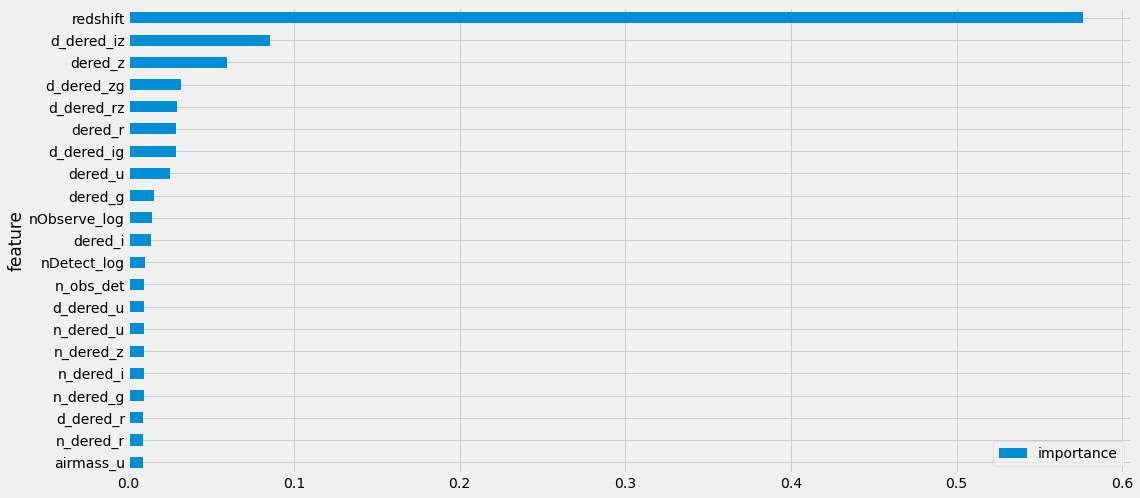

In [47]:
imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': xgb_clf1.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [50]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    xgb_clf2 = XGBClassifier(
        n_estimators = 1000,
        min_child_weight = 10,
         max_depth =12,
         learning_rate = 0.05, subsample= 0.9,
        gamma= 0.1,
        colsample_bytree = 1.0,
        random_state = 8,
        objective = 'multi:softmax')
    xgb_clf2.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=80)
    
    p_val[i_val, :] =xgb_clf2.predict_proba(trn[i_val])
    p_tst += xgb_clf2.predict_proba(tst) / n_fold

training model for CV #1
[0]	validation_0-merror:0.07919
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07730
[2]	validation_0-merror:0.07559
[3]	validation_0-merror:0.07527
[4]	validation_0-merror:0.07481
[5]	validation_0-merror:0.07467
[6]	validation_0-merror:0.07414
[7]	validation_0-merror:0.07409
[8]	validation_0-merror:0.07412
[9]	validation_0-merror:0.07405
[10]	validation_0-merror:0.07375
[11]	validation_0-merror:0.07344
[12]	validation_0-merror:0.07356
[13]	validation_0-merror:0.07300
[14]	validation_0-merror:0.07292
[15]	validation_0-merror:0.07292
[16]	validation_0-merror:0.07289
[17]	validation_0-merror:0.07259
[18]	validation_0-merror:0.07252
[19]	validation_0-merror:0.07255
[20]	validation_0-merror:0.07248
[21]	validation_0-merror:0.07253
[22]	validation_0-merror:0.07223
[23]	validation_0-merror:0.07227
[24]	validation_0-merror:0.07197
[25]	validation_0-merror:0.07191
[26]	validation_0-merror:0.07198
[27]	validation_0-merror:0.

[242]	validation_0-merror:0.06608
[243]	validation_0-merror:0.06606
[244]	validation_0-merror:0.06614
[245]	validation_0-merror:0.06616
[246]	validation_0-merror:0.06613
[247]	validation_0-merror:0.06616
[248]	validation_0-merror:0.06616
[249]	validation_0-merror:0.06617
[250]	validation_0-merror:0.06614
[251]	validation_0-merror:0.06617
[252]	validation_0-merror:0.06625
[253]	validation_0-merror:0.06622
[254]	validation_0-merror:0.06620
[255]	validation_0-merror:0.06619
[256]	validation_0-merror:0.06625
[257]	validation_0-merror:0.06627
[258]	validation_0-merror:0.06628
[259]	validation_0-merror:0.06628
[260]	validation_0-merror:0.06630
[261]	validation_0-merror:0.06630
[262]	validation_0-merror:0.06630
[263]	validation_0-merror:0.06633
[264]	validation_0-merror:0.06628
[265]	validation_0-merror:0.06625
[266]	validation_0-merror:0.06633
[267]	validation_0-merror:0.06627
[268]	validation_0-merror:0.06625
[269]	validation_0-merror:0.06623
[270]	validation_0-merror:0.06622
[271]	validati

[167]	validation_0-merror:0.06728
[168]	validation_0-merror:0.06725
[169]	validation_0-merror:0.06723
[170]	validation_0-merror:0.06727
[171]	validation_0-merror:0.06720
[172]	validation_0-merror:0.06723
[173]	validation_0-merror:0.06722
[174]	validation_0-merror:0.06719
[175]	validation_0-merror:0.06730
[176]	validation_0-merror:0.06727
[177]	validation_0-merror:0.06725
[178]	validation_0-merror:0.06731
[179]	validation_0-merror:0.06738
[180]	validation_0-merror:0.06744
[181]	validation_0-merror:0.06741
[182]	validation_0-merror:0.06736
[183]	validation_0-merror:0.06736
[184]	validation_0-merror:0.06744
[185]	validation_0-merror:0.06741
[186]	validation_0-merror:0.06738
[187]	validation_0-merror:0.06745
[188]	validation_0-merror:0.06738
[189]	validation_0-merror:0.06736
[190]	validation_0-merror:0.06731
[191]	validation_0-merror:0.06738
[192]	validation_0-merror:0.06744
[193]	validation_0-merror:0.06745
[194]	validation_0-merror:0.06739
[195]	validation_0-merror:0.06739
[196]	validati

[152]	validation_0-merror:0.06652
[153]	validation_0-merror:0.06659
[154]	validation_0-merror:0.06659
[155]	validation_0-merror:0.06661
[156]	validation_0-merror:0.06672
[157]	validation_0-merror:0.06669
[158]	validation_0-merror:0.06667
[159]	validation_0-merror:0.06667
[160]	validation_0-merror:0.06661
[161]	validation_0-merror:0.06658
[162]	validation_0-merror:0.06667
[163]	validation_0-merror:0.06659
[164]	validation_0-merror:0.06663
[165]	validation_0-merror:0.06666
[166]	validation_0-merror:0.06659
[167]	validation_0-merror:0.06655
[168]	validation_0-merror:0.06648
[169]	validation_0-merror:0.06648
[170]	validation_0-merror:0.06648
[171]	validation_0-merror:0.06652
[172]	validation_0-merror:0.06647
[173]	validation_0-merror:0.06652
[174]	validation_0-merror:0.06655
[175]	validation_0-merror:0.06653
[176]	validation_0-merror:0.06658
[177]	validation_0-merror:0.06658
[178]	validation_0-merror:0.06658
[179]	validation_0-merror:0.06656
[180]	validation_0-merror:0.06656
[181]	validati

[393]	validation_0-merror:0.06570
[394]	validation_0-merror:0.06575
[395]	validation_0-merror:0.06578
[396]	validation_0-merror:0.06575
[397]	validation_0-merror:0.06578
[398]	validation_0-merror:0.06577
[399]	validation_0-merror:0.06580
[400]	validation_0-merror:0.06581
[401]	validation_0-merror:0.06581
[402]	validation_0-merror:0.06586
[403]	validation_0-merror:0.06583
[404]	validation_0-merror:0.06580
[405]	validation_0-merror:0.06577
[406]	validation_0-merror:0.06573
[407]	validation_0-merror:0.06567
[408]	validation_0-merror:0.06567
[409]	validation_0-merror:0.06567
[410]	validation_0-merror:0.06566
[411]	validation_0-merror:0.06563
Stopping. Best iteration:
[331]	validation_0-merror:0.06563

training model for CV #4
[0]	validation_0-merror:0.08000
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07822
[2]	validation_0-merror:0.07792
[3]	validation_0-merror:0.07719
[4]	validation_0-merror:0.07644
[5]	validation_0-merror:0.07594
[6]	valid

[221]	validation_0-merror:0.06717
[222]	validation_0-merror:0.06731
[223]	validation_0-merror:0.06730
[224]	validation_0-merror:0.06728
[225]	validation_0-merror:0.06734
[226]	validation_0-merror:0.06723
[227]	validation_0-merror:0.06719
[228]	validation_0-merror:0.06719
[229]	validation_0-merror:0.06720
[230]	validation_0-merror:0.06713
[231]	validation_0-merror:0.06705
[232]	validation_0-merror:0.06709
[233]	validation_0-merror:0.06708
[234]	validation_0-merror:0.06709
[235]	validation_0-merror:0.06711
[236]	validation_0-merror:0.06703
[237]	validation_0-merror:0.06713
[238]	validation_0-merror:0.06716
[239]	validation_0-merror:0.06711
[240]	validation_0-merror:0.06719
[241]	validation_0-merror:0.06719
[242]	validation_0-merror:0.06717
[243]	validation_0-merror:0.06709
[244]	validation_0-merror:0.06702
[245]	validation_0-merror:0.06702
[246]	validation_0-merror:0.06703
[247]	validation_0-merror:0.06709
[248]	validation_0-merror:0.06713
[249]	validation_0-merror:0.06716
[250]	validati

[462]	validation_0-merror:0.06645
[463]	validation_0-merror:0.06638
[464]	validation_0-merror:0.06642
[465]	validation_0-merror:0.06641
[466]	validation_0-merror:0.06648
[467]	validation_0-merror:0.06652
[468]	validation_0-merror:0.06648
[469]	validation_0-merror:0.06650
[470]	validation_0-merror:0.06647
[471]	validation_0-merror:0.06648
[472]	validation_0-merror:0.06648
[473]	validation_0-merror:0.06652
[474]	validation_0-merror:0.06652
[475]	validation_0-merror:0.06648
[476]	validation_0-merror:0.06647
[477]	validation_0-merror:0.06652
[478]	validation_0-merror:0.06652
[479]	validation_0-merror:0.06644
[480]	validation_0-merror:0.06641
[481]	validation_0-merror:0.06645
[482]	validation_0-merror:0.06650
[483]	validation_0-merror:0.06647
[484]	validation_0-merror:0.06647
[485]	validation_0-merror:0.06641
[486]	validation_0-merror:0.06647
[487]	validation_0-merror:0.06647
[488]	validation_0-merror:0.06648
[489]	validation_0-merror:0.06650
[490]	validation_0-merror:0.06647
[491]	validati

[158]	validation_0-merror:0.06539
[159]	validation_0-merror:0.06550
[160]	validation_0-merror:0.06547
[161]	validation_0-merror:0.06550
[162]	validation_0-merror:0.06541
[163]	validation_0-merror:0.06536
[164]	validation_0-merror:0.06541
[165]	validation_0-merror:0.06534
[166]	validation_0-merror:0.06538
[167]	validation_0-merror:0.06536
[168]	validation_0-merror:0.06539
[169]	validation_0-merror:0.06542
[170]	validation_0-merror:0.06544
[171]	validation_0-merror:0.06545
[172]	validation_0-merror:0.06548
[173]	validation_0-merror:0.06552
[174]	validation_0-merror:0.06550
[175]	validation_0-merror:0.06545
[176]	validation_0-merror:0.06545
[177]	validation_0-merror:0.06539
[178]	validation_0-merror:0.06544
[179]	validation_0-merror:0.06544
[180]	validation_0-merror:0.06547
[181]	validation_0-merror:0.06544
[182]	validation_0-merror:0.06536
[183]	validation_0-merror:0.06534
[184]	validation_0-merror:0.06530
[185]	validation_0-merror:0.06538
[186]	validation_0-merror:0.06531
[187]	validati

[399]	validation_0-merror:0.06489
[400]	validation_0-merror:0.06491
[401]	validation_0-merror:0.06488
[402]	validation_0-merror:0.06486
[403]	validation_0-merror:0.06488
[404]	validation_0-merror:0.06484
[405]	validation_0-merror:0.06486
[406]	validation_0-merror:0.06483
[407]	validation_0-merror:0.06486
[408]	validation_0-merror:0.06488
[409]	validation_0-merror:0.06495
[410]	validation_0-merror:0.06484
[411]	validation_0-merror:0.06484
[412]	validation_0-merror:0.06491
[413]	validation_0-merror:0.06488
[414]	validation_0-merror:0.06478
[415]	validation_0-merror:0.06486
[416]	validation_0-merror:0.06491
[417]	validation_0-merror:0.06484
[418]	validation_0-merror:0.06488
[419]	validation_0-merror:0.06491
[420]	validation_0-merror:0.06491
[421]	validation_0-merror:0.06494
[422]	validation_0-merror:0.06494
[423]	validation_0-merror:0.06492
[424]	validation_0-merror:0.06492
[425]	validation_0-merror:0.06498
[426]	validation_0-merror:0.06497
[427]	validation_0-merror:0.06500
[428]	validati

In [51]:
print('personal xgb + kfold :')
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

personal xgb + kfold :
93.4006%


In [52]:
#pval ptst
algo_name = 'xgbcv2'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

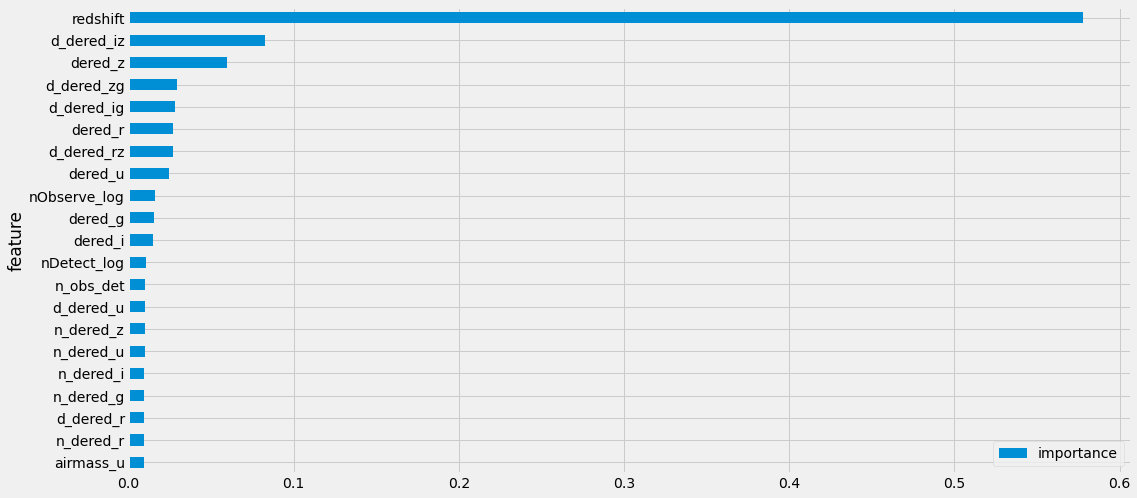

In [53]:
imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': xgb_clf1.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [57]:
cols_to_use_best = ['redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',

 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_rg',
 'n_dered_ig',
 'n_dered_zg',
 'n_dered_ri',
 'n_dered_rz',
 #'n_dered_iz',#?
 
 'nObserve_log',
 'nDetect_log'] #93.40

In [58]:
cols_to_use_predict = cols_to_use_best + ['n_dered_uz','n_dered_iz']

In [59]:
#최적 파라미터 찾는 부분
params = {
    "objective": "multi:softmax",
    "n_estimators": 1000,
    "random_state": seed,
    "n_jobs": -1
}

space = {
    'max_depth' : hp.choice('max_depth', range(5, 18, 1)),
    'min_child_weight' : hp.quniform('min_child_weight', 5, 20, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.1),
    'subsample' : hp.quniform('subsample', 0.7, 1.05, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1.0, 0.05)
}

def objective(hyperparams):
    model = XGBClassifier(**params, **hyperparams)
    model.fit(X=X_train, y=y_train,
              eval_set=[(X_test, y_test)],
              eval_metric="merror",
              early_stopping_rounds=30,
              verbose=False)
    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
#n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

#//ParamDone

#xg2. KFold Stratified



#1. Hyperparam + KFoldStratified XGB 


SCORE:                                                
0.067125                                              
SCORE:                                                                 
0.067671875                                                            
SCORE:                                                                 
0.067203125                                                            
SCORE:                                                                 
0.067921875                                                            
SCORE:                                                                 
0.06740625                                                             
SCORE:                                                                 
0.06840625                                                             
SCORE:                                                                 
0.067078125                                                            
SCORE:                    

KeyError: "['airmass_z' 'airmass_i' 'airmass_r' 'airmass_g'] not found in axis"

In [60]:

n_fold = 5
n_class = 3
#cv = KFold(n_splits = n_fold, shuffle = True, random_state = 1)
cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 1)

In [61]:
#df = make_col(feature)
y = df[target_col].values[:320000]
trn = df[cols_to_use_predict].iloc[:320000].values
tst = df[cols_to_use_predict].iloc[320000:].values
feature_name = df[cols_to_use_predict].columns.tolist()

In [62]:
feature_name

['redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_rg',
 'n_dered_ig',
 'n_dered_zg',
 'n_dered_ri',
 'n_dered_rz',
 'nObserve_log',
 'nDetect_log',
 'n_dered_uz',
 'n_dered_iz']

In [63]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    xgb_clf0 = XGBClassifier(**params)
    xgb_clf0.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=80)
    
    p_val[i_val, :] =xgb_clf0.predict_proba(trn[i_val])
    p_tst += xgb_clf0.predict_proba(tst) / n_fold

print('hyper xgb + kfold2 :')
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

print(p_val.shape, p_tst.shape)

training model for CV #1
[0]	validation_0-merror:0.07844
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07053
[2]	validation_0-merror:0.06933
[3]	validation_0-merror:0.07144
[4]	validation_0-merror:0.07053
[5]	validation_0-merror:0.07036
[6]	validation_0-merror:0.06994
[7]	validation_0-merror:0.06853
[8]	validation_0-merror:0.06808
[9]	validation_0-merror:0.06755
[10]	validation_0-merror:0.06755
[11]	validation_0-merror:0.06730
[12]	validation_0-merror:0.06709
[13]	validation_0-merror:0.06725
[14]	validation_0-merror:0.06752
[15]	validation_0-merror:0.06738
[16]	validation_0-merror:0.06708
[17]	validation_0-merror:0.06719
[18]	validation_0-merror:0.06720
[19]	validation_0-merror:0.06742
[20]	validation_0-merror:0.06722
[21]	validation_0-merror:0.06714
[22]	validation_0-merror:0.06727
[23]	validation_0-merror:0.06705
[24]	validation_0-merror:0.06702
[25]	validation_0-merror:0.06683
[26]	validation_0-merror:0.06697
[27]	validation_0-merror:0.

[242]	validation_0-merror:0.06466
[243]	validation_0-merror:0.06459
[244]	validation_0-merror:0.06461
[245]	validation_0-merror:0.06461
[246]	validation_0-merror:0.06456
[247]	validation_0-merror:0.06458
[248]	validation_0-merror:0.06455
[249]	validation_0-merror:0.06461
[250]	validation_0-merror:0.06459
[251]	validation_0-merror:0.06452
[252]	validation_0-merror:0.06455
[253]	validation_0-merror:0.06452
[254]	validation_0-merror:0.06453
[255]	validation_0-merror:0.06455
[256]	validation_0-merror:0.06450
[257]	validation_0-merror:0.06450
[258]	validation_0-merror:0.06450
[259]	validation_0-merror:0.06444
[260]	validation_0-merror:0.06450
[261]	validation_0-merror:0.06453
[262]	validation_0-merror:0.06453
[263]	validation_0-merror:0.06459
[264]	validation_0-merror:0.06453
[265]	validation_0-merror:0.06445
[266]	validation_0-merror:0.06450
[267]	validation_0-merror:0.06452
[268]	validation_0-merror:0.06456
[269]	validation_0-merror:0.06459
[270]	validation_0-merror:0.06455
[271]	validati

[483]	validation_0-merror:0.06433
[484]	validation_0-merror:0.06428
Stopping. Best iteration:
[404]	validation_0-merror:0.06425

training model for CV #2
[0]	validation_0-merror:0.07989
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07152
[2]	validation_0-merror:0.06997
[3]	validation_0-merror:0.07216
[4]	validation_0-merror:0.07089
[5]	validation_0-merror:0.07109
[6]	validation_0-merror:0.07116
[7]	validation_0-merror:0.06953
[8]	validation_0-merror:0.06905
[9]	validation_0-merror:0.06880
[10]	validation_0-merror:0.06898
[11]	validation_0-merror:0.06859
[12]	validation_0-merror:0.06844
[13]	validation_0-merror:0.06839
[14]	validation_0-merror:0.06892
[15]	validation_0-merror:0.06900
[16]	validation_0-merror:0.06858
[17]	validation_0-merror:0.06833
[18]	validation_0-merror:0.06839
[19]	validation_0-merror:0.06867
[20]	validation_0-merror:0.06847
[21]	validation_0-merror:0.06800
[22]	validation_0-merror:0.06808
[23]	validation_0-merror:0.067

[238]	validation_0-merror:0.06452
[239]	validation_0-merror:0.06447
[240]	validation_0-merror:0.06444
[241]	validation_0-merror:0.06452
[242]	validation_0-merror:0.06450
[243]	validation_0-merror:0.06445
[244]	validation_0-merror:0.06445
[245]	validation_0-merror:0.06447
[246]	validation_0-merror:0.06448
[247]	validation_0-merror:0.06444
[248]	validation_0-merror:0.06444
[249]	validation_0-merror:0.06439
[250]	validation_0-merror:0.06441
[251]	validation_0-merror:0.06436
[252]	validation_0-merror:0.06439
[253]	validation_0-merror:0.06439
[254]	validation_0-merror:0.06438
[255]	validation_0-merror:0.06431
[256]	validation_0-merror:0.06433
[257]	validation_0-merror:0.06428
[258]	validation_0-merror:0.06433
[259]	validation_0-merror:0.06434
[260]	validation_0-merror:0.06438
[261]	validation_0-merror:0.06434
[262]	validation_0-merror:0.06436
[263]	validation_0-merror:0.06434
[264]	validation_0-merror:0.06436
[265]	validation_0-merror:0.06436
[266]	validation_0-merror:0.06433
[267]	validati

[140]	validation_0-merror:0.06475
[141]	validation_0-merror:0.06475
[142]	validation_0-merror:0.06481
[143]	validation_0-merror:0.06484
[144]	validation_0-merror:0.06470
[145]	validation_0-merror:0.06472
[146]	validation_0-merror:0.06483
[147]	validation_0-merror:0.06480
[148]	validation_0-merror:0.06481
[149]	validation_0-merror:0.06473
[150]	validation_0-merror:0.06470
[151]	validation_0-merror:0.06466
[152]	validation_0-merror:0.06466
[153]	validation_0-merror:0.06469
[154]	validation_0-merror:0.06466
[155]	validation_0-merror:0.06461
[156]	validation_0-merror:0.06459
[157]	validation_0-merror:0.06453
[158]	validation_0-merror:0.06448
[159]	validation_0-merror:0.06450
[160]	validation_0-merror:0.06444
[161]	validation_0-merror:0.06448
[162]	validation_0-merror:0.06452
[163]	validation_0-merror:0.06441
[164]	validation_0-merror:0.06442
[165]	validation_0-merror:0.06431
[166]	validation_0-merror:0.06439
[167]	validation_0-merror:0.06447
[168]	validation_0-merror:0.06442
[169]	validati

[100]	validation_0-merror:0.06545
[101]	validation_0-merror:0.06541
[102]	validation_0-merror:0.06547
[103]	validation_0-merror:0.06542
[104]	validation_0-merror:0.06545
[105]	validation_0-merror:0.06547
[106]	validation_0-merror:0.06548
[107]	validation_0-merror:0.06534
[108]	validation_0-merror:0.06533
[109]	validation_0-merror:0.06522
[110]	validation_0-merror:0.06522
[111]	validation_0-merror:0.06520
[112]	validation_0-merror:0.06517
[113]	validation_0-merror:0.06522
[114]	validation_0-merror:0.06519
[115]	validation_0-merror:0.06523
[116]	validation_0-merror:0.06517
[117]	validation_0-merror:0.06514
[118]	validation_0-merror:0.06522
[119]	validation_0-merror:0.06517
[120]	validation_0-merror:0.06513
[121]	validation_0-merror:0.06509
[122]	validation_0-merror:0.06516
[123]	validation_0-merror:0.06511
[124]	validation_0-merror:0.06505
[125]	validation_0-merror:0.06508
[126]	validation_0-merror:0.06513
[127]	validation_0-merror:0.06511
[128]	validation_0-merror:0.06511
[129]	validati

[341]	validation_0-merror:0.06391
[342]	validation_0-merror:0.06392
[343]	validation_0-merror:0.06391
[344]	validation_0-merror:0.06394
[345]	validation_0-merror:0.06398
[346]	validation_0-merror:0.06400
[347]	validation_0-merror:0.06406
[348]	validation_0-merror:0.06403
[349]	validation_0-merror:0.06402
[350]	validation_0-merror:0.06398
[351]	validation_0-merror:0.06400
[352]	validation_0-merror:0.06397
[353]	validation_0-merror:0.06400
[354]	validation_0-merror:0.06398
[355]	validation_0-merror:0.06394
[356]	validation_0-merror:0.06398
[357]	validation_0-merror:0.06400
[358]	validation_0-merror:0.06400
[359]	validation_0-merror:0.06400
[360]	validation_0-merror:0.06402
[361]	validation_0-merror:0.06398
[362]	validation_0-merror:0.06402
[363]	validation_0-merror:0.06400
[364]	validation_0-merror:0.06403
[365]	validation_0-merror:0.06405
[366]	validation_0-merror:0.06403
[367]	validation_0-merror:0.06403
[368]	validation_0-merror:0.06405
[369]	validation_0-merror:0.06406
[370]	validati

[166]	validation_0-merror:0.06295
[167]	validation_0-merror:0.06300
[168]	validation_0-merror:0.06297
[169]	validation_0-merror:0.06294
[170]	validation_0-merror:0.06297
[171]	validation_0-merror:0.06289
[172]	validation_0-merror:0.06297
[173]	validation_0-merror:0.06295
[174]	validation_0-merror:0.06281
[175]	validation_0-merror:0.06289
[176]	validation_0-merror:0.06288
[177]	validation_0-merror:0.06281
[178]	validation_0-merror:0.06289
[179]	validation_0-merror:0.06283
[180]	validation_0-merror:0.06291
[181]	validation_0-merror:0.06284
[182]	validation_0-merror:0.06281
[183]	validation_0-merror:0.06288
[184]	validation_0-merror:0.06292
[185]	validation_0-merror:0.06297
[186]	validation_0-merror:0.06305
[187]	validation_0-merror:0.06306
[188]	validation_0-merror:0.06308
[189]	validation_0-merror:0.06305
[190]	validation_0-merror:0.06306
[191]	validation_0-merror:0.06302
[192]	validation_0-merror:0.06308
[193]	validation_0-merror:0.06300
[194]	validation_0-merror:0.06297
[195]	validati

[407]	validation_0-merror:0.06208
[408]	validation_0-merror:0.06205
[409]	validation_0-merror:0.06203
[410]	validation_0-merror:0.06203
[411]	validation_0-merror:0.06200
[412]	validation_0-merror:0.06200
[413]	validation_0-merror:0.06195
[414]	validation_0-merror:0.06198
[415]	validation_0-merror:0.06198
[416]	validation_0-merror:0.06206
[417]	validation_0-merror:0.06200
[418]	validation_0-merror:0.06200
[419]	validation_0-merror:0.06198
[420]	validation_0-merror:0.06195
[421]	validation_0-merror:0.06192
[422]	validation_0-merror:0.06192
[423]	validation_0-merror:0.06194
[424]	validation_0-merror:0.06192
[425]	validation_0-merror:0.06189
[426]	validation_0-merror:0.06189
[427]	validation_0-merror:0.06191
[428]	validation_0-merror:0.06187
[429]	validation_0-merror:0.06195
[430]	validation_0-merror:0.06191
[431]	validation_0-merror:0.06194
[432]	validation_0-merror:0.06195
[433]	validation_0-merror:0.06194
[434]	validation_0-merror:0.06194
[435]	validation_0-merror:0.06200
[436]	validati

In [64]:
sub= submission
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,id,class
0,320000,2
1,320001,0
2,320002,2
3,320003,0
4,320004,2


In [65]:
sub.shape

(80000, 2)

In [66]:
sub.to_csv("xgboostHyperopt_uzfeature.csv",index=False, encoding='utf-8-sig')

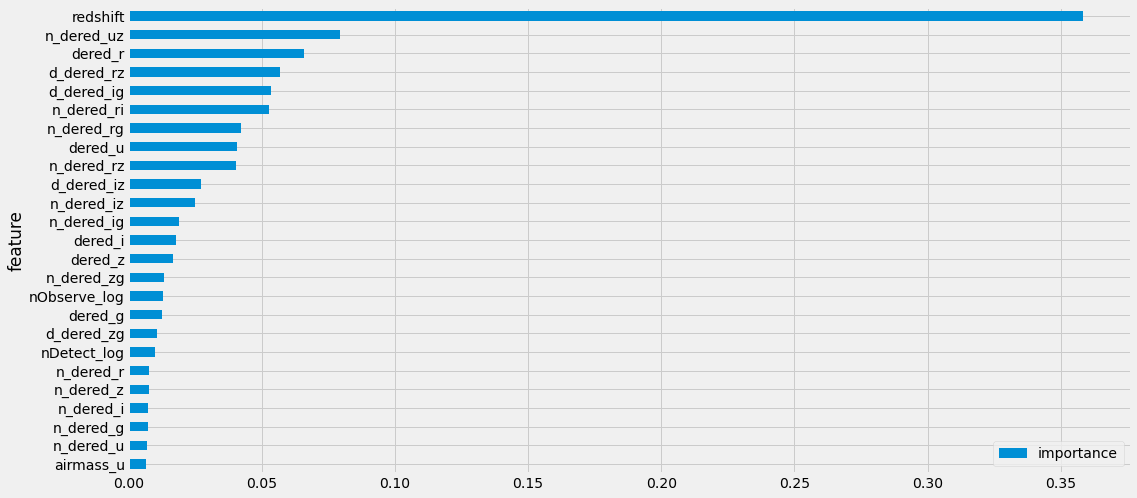

In [68]:
imp = pd.DataFrame({'feature': df[cols_to_use_predict].columns, 'importance': xgb_clf0.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [67]:
algo_name = 'xgbcv_best'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

LGBM Best Param

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
# n_estimators = 100? 500? 1000?
lgb_clf = lgb.LGBMClassifier(n_estimators = 1000, n_jobs =-1,
                            objective = 'multiclass',
                            min_child_sample = 10,
                             learning_rate = 0.115,
                             num_leaves = 128,
                        
                            )
params = {
          'subsample' : [1, .8]
         }
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv=3 )
gridcv.fit(X_train,y_train,early_stopping_rounds = 80, eval_set=[(X_test,y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test,gridcv.predict(X_test))
print('ROC AUC : {0.4f}'.format(xgb_roc_score))


In [ ]:
import lightgbm as lgb
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    lgb_clf0 = lgb.LGBMClassifier(n_estimators = 1000, 
                        min_child_samples = 10,
                        num_leaves =128,
                        learning_rate = 0.1,
                        objective = 'multiclass')
    lgb_clf0.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=80)
    
    p_val[i_val, :] = lgb_clf0.predict_proba(trn[i_val])
    p_tst += lgb_clf0.predict_proba(tst) / n_fold

In [ ]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

In [ ]:
imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': lgb_clf0.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [ ]:
imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': lgb_clf0.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [ ]:
from sklearn.model_selection import GridSearchCV
# n_estimators = 100? 500? 1000?
xgb_clf = XGBClassifier(n_estimators = 800, 
                        min_child_weight = 4 ,
                        max_depth =12,
                        learning_rate = 0.115,
                        verbose = False,
                        objective = 'multi:softmax')
xgb_clf.fit(X_train,y_train, early_stopping_rounds = 90, eval_set=[(X_test,y_test)])
xgb_roc_score = roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC : {0.6f}'.format(xgb_roc_score))


In [ ]:
from xgboost import XGBClassifier
seed = 1
my_model = XGBClassifier(
                         max_depth = 12,
                         nthread = 8,
                         objective = 'multi:softmax',
                         n_estimators =800,
                        min_child_weight =4,
                        subsample =1,
                         learning_rate = 0.115,
                        seed = seed
                        )
evals = [(X_test, y_test)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= my_model.fit(X_train,y_train, early_stopping_rounds=80, eval_set=evals, verbose = True)

In [ ]:
y_pred = my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

In [ ]:
cv = KFold(5, shuffle=True, random_state=0)

In [ ]:
cross_val_score(my_model, X, y, scoring='accuracy', cv=cv)

In [ ]:
from xgboost import plot_tree, to_graphviz
plot_tree(gridcv,figsize = 1000)
to_graphviz(gridcv,outfile = 'download.png')

In [ ]:
import graphviz
dot_data = export_graphviz(my_model, out_file =None,
                          feature_names = cols_to_use,
                           filled = True,
                           rounded = True,
                           special_characters = True
                          )

graph = graphviz.Source(dot_data)
graph

In [ ]:
pred_probs = my_model.predict(X_test)
pred_probs

In [ ]:
plot_importance(my_model)

In [ ]:
y_pred =my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

In [ ]:
Y_pred = lgb_clf0.predict(testX)
predictions = [int(round(value)) for value in Y_pred]
predictions

In [ ]:
probas = my_model.predict_proba(testX)
np.round(probas,4)
df_probas = pd.DataFrame(np.round(probas,4))
df_probas.head(20)

In [ ]:
for i in range(80000):
    if float(df_probas.iloc[i][0]) > 0.99 :
        print(test_sure.iloc[i])

In [ ]:
predictions = [ 1 if x >0.5 and x < 1.5 else ( 0 if x >-0.5 and x< 0.5 else 2) for x in predictions ]

In [ ]:
# final result
submission['class'] = predictions
submission.to_csv("8020LGBM_93,52_makedata_eta0115_redshiftlog.csv",index=False, encoding='utf-8-sig')